In [1]:
import pandas as pd
import numpy as np

In [7]:
data = pd.read_csv('D:\carse\Datasets\healthcare-dataset-stroke-data.csv')
data = data.drop(['id'], axis= 1)
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [8]:
data = data.dropna()
data.isna()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
5104,False,False,False,False,False,False,False,False,False,False,False
5106,False,False,False,False,False,False,False,False,False,False,False
5107,False,False,False,False,False,False,False,False,False,False,False
5108,False,False,False,False,False,False,False,False,False,False,False


In [21]:
data.stroke.value_counts()

0    4700
1     209
Name: stroke, dtype: int64

Heavily skewed towards not having a stroke

In [9]:
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler

In [10]:
transformer = make_column_transformer((OneHotEncoder(handle_unknown='ignore'),
                                        ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']),
                                      (MinMaxScaler(), ['age', 'avg_glucose_level', 'bmi']),
                                      remainder='passthrough')

In [12]:
from sklearn.model_selection import train_test_split

target = data.stroke.values
features = data[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']].copy()
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=0)


In [13]:
w = {0: 1, 1:40}
model = make_pipeline(
    transformer,
    LogisticRegression(class_weight = w))
model.fit(X_train, y_train)
print("logistic regression score: %f" % model.score(X_test, y_test))

logistic regression score: 0.624593


In [14]:
from sklearn.metrics import f1_score

f1_score(y_test, model.predict(X_test))

0.16636528028933092

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

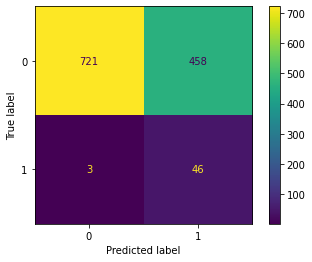

In [17]:
plot_confusion_matrix(model, X_test, y_test)
plt.show()

In [18]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(loss = 'deviance', criterion = 'friedman_mse')

gbc_pipe = make_pipeline(
    transformer,
    gbc)
gbc_pipe.fit(X_train, y_train)
print("GBC Score: %f" % gbc_pipe.score(X_test, y_test))

GBC Score: 0.955212


In [19]:
f1_score(y_test, gbc_pipe.predict(X_test))

0.0

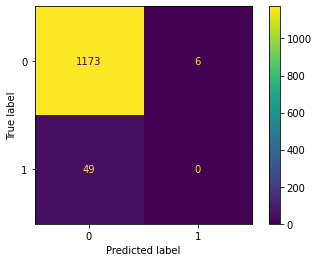

In [20]:
plot_confusion_matrix(gbc_pipe, X_test, y_test)
plt.show()